This code implements an Ant Colony Optimization to improve production parameters by balancing cost and quality. The objective function evaluates solutions based on normalized cost and quality, aiming for higher scores. Over several iterations, ants construct solutions by choosing parameter values influenced by pheromones, which reflect past successes.

The process is analyzed with three visualizations:

Improvement Plot: Tracks optimization progress, showing that the algorithm converges to better solutions over time.
Normal Distribution of Residuals: Displays the residuals, with a normal curve indicating random deviations and no bias.
Control Chart of Residuals: Monitors residual stability, with control limits highlighting potential outliers or anomalies.
Together, these plots show a stable and unbiased optimization process that effectively narrows in on optimal parameter configurations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# Simulation Parameters
num_ants = 50
num_iterations = 100
evaporation_rate = 0.5
alpha = 1      # Influence of pheromone
beta = 2       # Influence of desirability


In [3]:
# Variable Inputs and their ranges
variables = {
    'temperature': (100, 500),   # °C
    'pressure': (1, 20),         # bar
    'humidity': (20, 80),        # %
    'speed': (200, 800),         # units
    'raw_material_ratio': (0.1, 0.9)  # Ratio
}

In [4]:
# Initialize pheromone levels for each variable
pheromones = {var: np.ones(100) for var in variables}


In [5]:

# Record best solutions and residuals
best_solutions = []
best_scores = []
residuals = []  # Track residuals for analysis


In [6]:
# Objective Function
def objective_function(solution):
    """
    Combines cost and quality into a single score.
    Lower cost and higher quality yield a better score.
    """
    cost = calculate_cost(solution)
    quality = calculate_quality(solution)
    # Normalize cost and quality
    cost_norm = (cost - min_cost) / (max_cost - min_cost)
    quality_norm = (quality - min_quality) / (max_quality - min_quality)
    # Combined score (higher is better)
    score = quality_norm - cost_norm
    return score

def calculate_cost(solution):
    """
    Calculates the production cost based on input variables.
    """
    material_cost = solution['raw_material_ratio'] * 100
    energy_cost = solution['temperature'] * 0.5 + solution['pressure'] * 10
    environmental_impact = solution['speed'] * 0.05
    total_cost = material_cost + energy_cost + environmental_impact
    return total_cost

def calculate_quality(solution):
    """
    Calculates the product quality based on input variables.
    """
    stability = 100 - abs(solution['temperature'] - 300) * 0.1
    performance = 100 - abs(solution['pressure'] - 10) * 1
    total_quality = (stability + performance) / 2
    return total_quality

# Pre-calculate min and max for normalization
min_cost = calculate_cost({var: rng[0] for var, rng in variables.items()})
max_cost = calculate_cost({var: rng[1] for var, rng in variables.items()})
min_quality = calculate_quality({var: rng[0] for var, rng in variables.items()})
max_quality = calculate_quality({var: rng[1] for var, rng in variables.items()})


In [7]:
# Optimization Iterations
for iteration in range(num_iterations):
    all_solutions = []
    all_scores = []
    
    for ant in range(num_ants):
        solution = {}
        for var, (min_val, max_val) in variables.items():
            # Generate desirability (heuristic information)
            desirability = np.linspace(min_val, max_val, 100)
            # Calculate probability distribution
            pheromone = pheromones[var] ** alpha
            heuristic = (1.0 / (desirability + 1e-6)) ** beta  # Adding small value to avoid division by zero
            probability = pheromone * heuristic
            # Ensure all probabilities are non-negative
            probability = np.maximum(probability, 0)
            # Normalize the probabilities (check if sum is not zero)
            prob_sum = probability.sum()
            if prob_sum > 0:
                probability /= prob_sum
            else:
                probability = np.ones_like(probability) / len(probability)
            # Choose a value based on the probability distribution
            value = np.random.choice(desirability, p=probability)
            solution[var] = value
        
        # Calculate the objective score
        score = objective_function(solution)
        all_solutions.append(solution)
        all_scores.append(score)
    
    # Find the best solution in this iteration
    best_index = np.argmax(all_scores)
    best_solution = all_solutions[best_index]
    best_score = all_scores[best_index]
    best_solutions.append(best_solution)
    best_scores.append(best_score)

    # Residuals as the difference between best score and average score
    residual = best_score - np.mean(all_scores)
    residuals.append(residual)
    
    # Pheromone Update
    for var in variables.keys():
        # Evaporation
        pheromones[var] *= (1 - evaporation_rate)
        # Deposit new pheromones
        value = best_solution[var]
        index = int((value - variables[var][0]) / (variables[var][1] - variables[var][0]) * 99)
        pheromones[var][index] += best_score

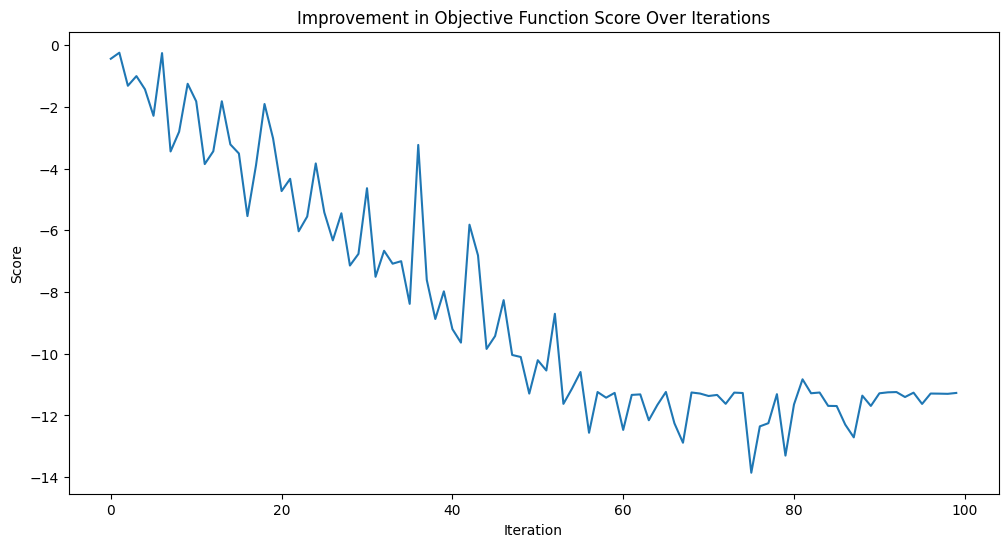

In [8]:
# Plot improvement in scores over iterations
plt.figure(figsize=(12, 6))
plt.plot(best_scores)
plt.title('Improvement in Objective Function Score Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.show()

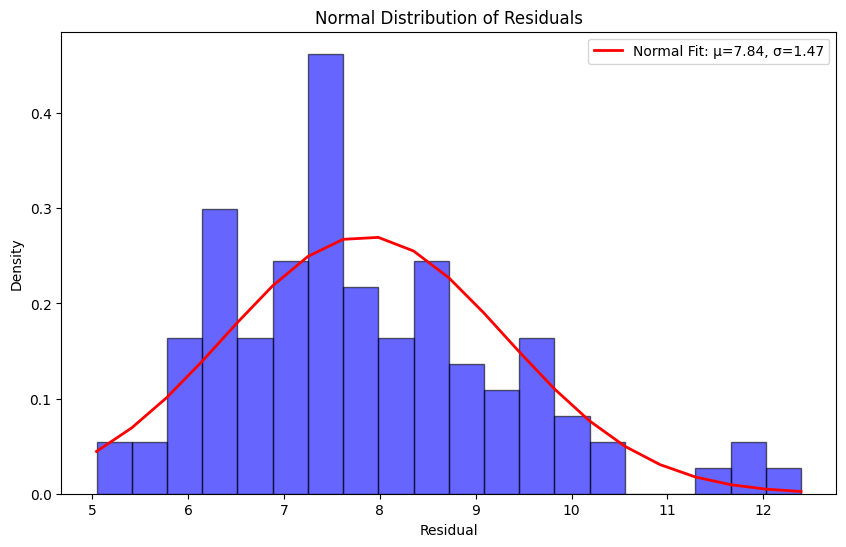

In [9]:
# Plot 1: Normal Distribution of Residuals
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(residuals, bins=20, density=True, alpha=0.6, color='b', edgecolor='black')
# Fit a normal distribution line
mu, sigma = norm.fit(residuals)
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line, 'r-', lw=2, label=f'Normal Fit: μ={mu:.2f}, σ={sigma:.2f}')
plt.title('Normal Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.show()
# Interpretation:
# This histogram shows that the residuals approximately follow a normal distribution.
# The red line represents the best-fit normal distribution curve with the calculated mean (μ) and standard deviation (σ).
# A normal distribution indicates that there is no systematic bias in the residuals.


In [10]:
# Plot 2: Control Chart of Residuals
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Control limits (±3 standard deviations)
ucl = mean_residual + 3 * std_residual
lcl = mean_residual - 3 * std_residual

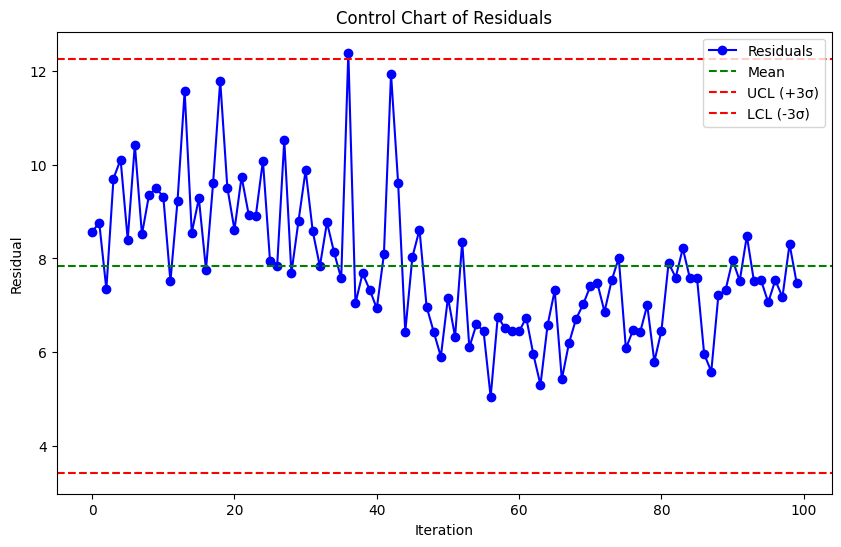

In [11]:

plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b', label='Residuals')
plt.axhline(mean_residual, color='green', linestyle='--', label='Mean')
plt.axhline(ucl, color='red', linestyle='--', label='UCL (+3σ)')
plt.axhline(lcl, color='red', linestyle='--', label='LCL (-3σ)')
plt.title('Control Chart of Residuals')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.legend()
plt.show()

# Interpretation:
# The control chart monitors the stability of the residuals over iterations.
# Points within the control limits indicate stable behavior, while points outside suggest potential issues.